In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy.crs as ccrs

import gcpy
import gcpy.benchmark as gcbm

In [2]:
# Useful for development
from importlib import reload
reload(gcpy)
reload(gcbm)

<module 'gcpy.benchmark' from '/Users/zhuangjw/Research/Computing/GCPy/gcpy/gcpy/benchmark.py'>

# Read input data

Use restart file as an example. Available at:

    ftp://ftp.as.harvard.edu/gcgrid/data/ExtData/NC_RESTARTS/initial_GEOSChem_rst.4x5_benchmark.nc

TODO: Use a diagnostic file instead.

In [3]:
ds = xr.open_dataset('../../data/restart/initial_GEOSChem_rst.4x5_benchmark.nc')
ds = ds.squeeze(drop=True) # remove time dimension

The `lev` dimension contains sigma values. Change to array indices for plotting.

TODO: Convert to pressure or height.

In [4]:
ds['lev'] = np.arange(1, ds['lev'].size+1)
ds['lev']

<xarray.DataArray 'lev' (lev: 72)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72])
Coordinates:
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...

## Perturb original data

Create another DataSet by perturbing the original DataSet.

In [5]:
def make_noise(shape):
    noise = np.random.rand(*shape)
    noise = 1.0 + 0.1 * (noise - 0.5)
    return noise

ds_perturbed = ds.copy() # don't change original dataset
for name, dr in ds_perturbed.data_vars.items():
    dr *= make_noise(dr.shape)

In [6]:
# calculate the difference between two DataSets
ds_diff = ds - ds_perturbed

TODO: read another DataSet from file (e.g. old version vs new version, GCHP vs GCC...)

# Plotting on map

## Basic plot

Before massively plotting all variables. We need to design the style for each single panel. I've written a convenience plotting function `gcbm.plot_layer()` to plot a 2D lat-lon DataArray. Quite similar to `tvmap` in gamap.

In [7]:
dr = ds['TRC_O3'].isel(lev=0) # get a 2D lat-lon DataArray
dr

<xarray.DataArray 'TRC_O3' (lat: 46, lon: 72)>
array([[  2.615237e-08,   2.615237e-08,   2.615237e-08, ...,   2.615237e-08,
          2.615237e-08,   2.615237e-08],
       [  2.622411e-08,   2.622632e-08,   2.623010e-08, ...,   2.620527e-08,
          2.622198e-08,   2.620175e-08],
       [  2.570759e-08,   2.548167e-08,   2.513250e-08, ...,   2.592743e-08,
          2.566281e-08,   2.570589e-08],
       ..., 
       [  8.588493e-09,   9.013182e-09,   8.793466e-09, ...,   8.650769e-09,
          8.041175e-09,   8.159272e-09],
       [  6.469575e-09,   6.469804e-09,   6.465895e-09, ...,   6.476197e-09,
          6.476856e-09,   6.473523e-09],
       [  6.460082e-09,   6.460082e-09,   6.460082e-09, ...,   6.460082e-09,
          6.460082e-09,   6.460082e-09]])
Coordinates:
    lev      int64 1
  * lat      (lat) float32 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 -66.0 -62.0 ...
  * lon      (lon) float32 -180.0 -175.0 -170.0 -165.0 -160.0 -155.0 -150.0 ...
Attributes:
    long_name:  O3 tracer


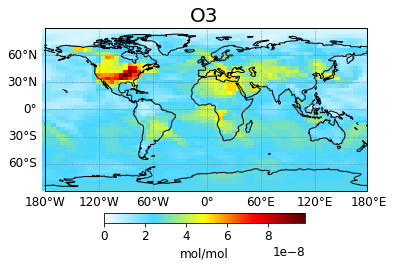

In [8]:
fig, ax = plt.subplots(1, 1, figsize=[6,4],
                       subplot_kw={'projection': ccrs.PlateCarree()})

gcbm.plot_layer(dr, ax, title='O3', unit=dr.units)

The actual benchmark function will call this basic plotting function multiple times, with exactly the same plotting style. 

### Note on input axis

The input axis must be cartopy "GeoAxes", not just matplotlib "Axes".

In [9]:
type(ax)

cartopy.mpl.geoaxes.GeoAxesSubplot

AssertionError: Input axis must be cartopy GeoAxes! Can be created by: 
plt.axes(projection=ccrs.PlateCarree()) 
 or 
plt.subplots(n, m, subplot_kw={'projection': ccrs.PlateCarree()})

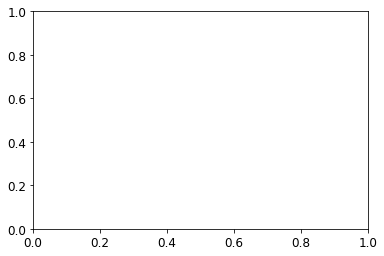

In [10]:
# fail on purpose
fig, ax = plt.subplots(1, 1, figsize=[6,4]) # forget to use projection
gcbm.plot_layer(dr, ax, title='O3', unit=dr.units)

### Difference plot

The same function can also plot difference. Just add `diff=True` keyword.

In [11]:
dr_diff = ds_diff['TRC_O3'].isel(lev=0) 
dr_diff # a DataArray representing difference

<xarray.DataArray 'TRC_O3' (lat: 46, lon: 72)>
array([[  1.079674e-09,  -1.112141e-09,  -9.800608e-11, ...,   4.866356e-10,
          4.878788e-10,   7.887604e-10],
       [  1.101367e-09,  -1.033523e-10,  -1.033235e-09, ...,   1.125968e-09,
          1.220195e-09,   9.345022e-10],
       [ -1.054702e-09,  -5.201595e-11,   1.016282e-09, ...,  -1.022587e-09,
         -1.008695e-10,   1.058939e-09],
       ..., 
       [  2.192598e-10,   4.383147e-10,   9.803208e-11, ...,   3.783984e-10,
         -1.043991e-10,   1.830829e-10],
       [ -3.012358e-11,  -1.781828e-10,   6.604504e-11, ...,  -1.131568e-10,
          2.870705e-10,  -2.805173e-10],
       [  3.067563e-10,   3.119919e-10,  -1.482202e-10, ...,  -1.588215e-10,
          4.369419e-11,   2.709603e-10]])
Coordinates:
    lev      int64 1
  * lat      (lat) float32 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 -66.0 -62.0 ...
  * lon      (lon) float32 -180.0 -175.0 -170.0 -165.0 -160.0 -155.0 -150.0 ...

Note that attributes like "units" are dropped after arithmetic operations (https://github.com/pydata/xarray/issues/1614), so we need to provide the unit manually here.

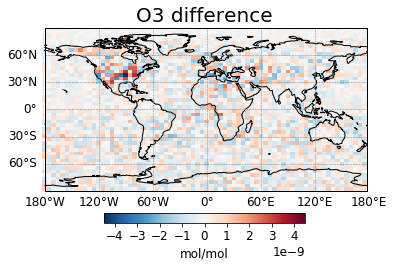

In [12]:
fig, ax = plt.subplots(1, 1, figsize=[6,4],
                       subplot_kw={'projection': ccrs.PlateCarree()})
    
gcbm.plot_layer(dr_diff, ax, title='O3 difference', 
                diff=True, unit='mol/mol')

### Subplots

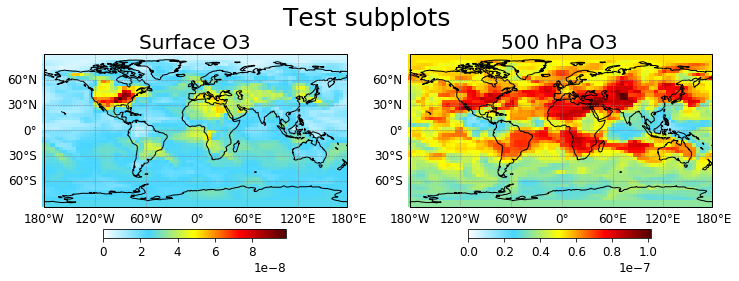

In [13]:
fig, axes = plt.subplots(1, 2, figsize=[12,4],
                       subplot_kw={'projection': ccrs.PlateCarree()})

gcbm.plot_layer(ds['TRC_O3'].isel(lev=0), axes[0], title='Surface O3')
gcbm.plot_layer(ds['TRC_O3'].isel(lev=22), axes[1], title='500 hPa O3')
fig.suptitle('Test subplots', fontsize=25, y=1.01)

### All options

In [14]:
help(gcbm.plot_layer)

Help on function plot_layer in module gcpy.benchmark:

plot_layer(dr, ax, title='', unit='', diff=False)
    Plot 2D DataArray as a lat-lon layer
    
    Parameters
    ----------
    dr : xarray.DataArray
        Dimension should be [lat, lon]
    
    ax : Cartopy GeoAxes object with PlateCarree projection
        Axis on which to plot this figure
    
    title : string, optional
        Title of the figure
    
    unit : string, optional
        Unit shown near the colorbar
    
    diff : Boolean, optional
        Switch to the color scale for difference plot



## Multi-page pdf

### Standard surface+500 hpa plot

In [15]:
ds_surf = ds.isel(lev=0)
ds_500hpa = ds.isel(lev=22)

In [16]:
%%time
gcbm.make_pdf(ds_surf, ds_500hpa, 'Surface_and_500hPa.pdf', unit='mol/mol',
              title1='Surface', title2='500 hPa')

Benchmarking 119 variables
generating a 40-page pdf
Page: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 done!
CPU times: user 45.8 s, sys: 742 ms, total: 46.5 s
Wall time: 46.9 s


### Subsetting variables

In [17]:
varlist = list(ds.data_vars.keys())[0:6]
varlist

['TRC_NO', 'TRC_O3', 'TRC_PAN', 'TRC_CO', 'TRC_ALK4', 'TRC_ISOP']

In [ ]:
ds_subset = ds[varlist]
ds_subset

<xarray.Dataset>
Dimensions:   (lat: 46, lev: 72, lon: 72)
Coordinates:
  * lat       (lat) float32 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 -66.0 -62.0 ...
  * lev       (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * lon       (lon) float32 -180.0 -175.0 -170.0 -165.0 -160.0 -155.0 -150.0 ...
Data variables:
    TRC_NO    (lev, lat, lon) float64 2.561e-17 2.561e-17 2.561e-17 ...
    TRC_O3    (lev, lat, lon) float64 2.615e-08 2.615e-08 2.615e-08 ...
    TRC_PAN   (lev, lat, lon) float64 8.709e-12 8.709e-12 8.709e-12 ...
    TRC_CO    (lev, lat, lon) float64 6.75e-08 6.75e-08 6.75e-08 6.75e-08 ...
    TRC_ALK4  (lev, lat, lon) float64 1.753e-10 1.753e-10 1.753e-10 ...
    TRC_ISOP  (lev, lat, lon) float64 5.959e-14 5.959e-14 5.959e-14 ...
Attributes:
    Title:        COARDS/netCDF file created by BPCH2COARDS (GAMAP v2-17+)
    Conventions:  COARDS
    Format:       NetCDF-3
    Model:        GEOS5
    Delta_Lon:    5.0
    Delta_Lat:    4.0
    NLayers:      72
    

`gcbm.make_pdf` is a universal framework to produce massive subplots on a pdf file. It can plot any two DataSets with 2 dimensions, and doesn't care what the data actually means.

In [ ]:
%%time
gcbm.make_pdf(ds_subset.isel(lev=9), ds_subset.isel(lev=19), 
             '10L_and_20L.pdf', unit='mol/mol',
              title1='10-th level', title2='20-th level')

Benchmarking 6 variables
generating a 2-page pdf
Page: 0 

### Difference plot

To switch to difference plot, the only changes are
- Provide DataSets containing difference data.
- Set `diff=True` to adjust colormap and colorbar range

In [ ]:
ds_diff_subset = ds_diff[varlist] # only plot a subset to save time

In [ ]:
%%time
gcbm.make_pdf(ds_diff_subset.isel(lev=0), ds_diff_subset.isel(lev=22), 
              'map_difference.pdf', unit='mol/mol',
              title1='Surface', title2='500 hPa', diff=True)

# Plot zonal profile

## Basic plot

`gcbm.plot_zonal()` is another convenience function, similar to `tvplot` in gamap.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[4, 4])
gcbm.plot_zonal(ds['TRC_NO'].isel(lon=0), ax, 
                title='NO zonal profile', unit='mol/mol')

In [ ]:
help(gcbm.plot_zonal)

### Difference plot

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[4, 4])
gcbm.plot_zonal(ds_diff['TRC_NO'].isel(lon=0), ax,
                title='NO difference', diff=True)

## Stratosphere only

Just need to slice the DataArray.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[5, 4])
gcbm.plot_zonal(ds['TRC_NO'].isel(lon=0).isel(lev=slice(32, -1)), 
                ax, title='statospheric NO', unit='mol/mol')

## Multi-page PDF

The only change to map-plotting is setting `on_map=False`.

In [ ]:
%%time
gcbm.make_pdf(ds.isel(lon=0), ds.mean(dim='lon'), 
              'zonal.pdf', on_map=False, unit='mol/mol',
              title1='180$\degree$', title2='zonal mean')

### Difference plot

The only change is to add `diff=True`. Use a subset to save time here.

In [ ]:
%%time
gcbm.make_pdf(ds_diff_subset.isel(lon=0), ds_diff_subset.mean(dim='lon'), 
              'zonal_difference.pdf', on_map=False, diff=True, unit='mol/mol',
              title1='180$\degree$', title2='zonal mean')

### stratosphere only

Simply slice the entire DataSet. Again, `gcbm.make_pdf()` is a universal framework that works for any 2D DataSets.

In [ ]:
ds_strato = ds_subset.isel(lev=slice(32, -1))

In [ ]:
%%time
gcbm.make_pdf(ds_strato.isel(lon=0), ds_strato.mean(dim='lon'), 
              'zonal_stratosphere.pdf', on_map=False, unit='mol/mol',
              title1='180$\degree$', title2='zonal mean')

### All options

In [ ]:
help(gcbm.make_pdf)